<a href="https://colab.research.google.com/github/michellecxy015/search-engines/blob/main/code/google_clip.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pandas torch torchvision transformers Pillow

In [1]:
import pandas as pd
import base64
from io import BytesIO
from PIL import Image
import requests
from transformers import CLIPProcessor, CLIPModel

In [14]:

# Load CLIP model and processor
model = CLIPModel.from_pretrained("openai/clip-vit-base-patch32")
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

# Define categories with prompts
categories = {
    "safe for children": [
        "This image is suitable for children.",
        "This image contains friendly and educational content.",
        "This image is child-appropriate.",
        "This image contains no harmful or inappropriate content."
    ],
    "violence": [
        "This image depicts violence.",
        "This image contains weapons.",
        "This image depicts fights or bullying.",
        "This image contains blood or gore."
    ],
    "sexual content": [
        "This image contains nudity.",
        "This image is sexually explicit.",
        "This image is pornographic.",
        "This image contains inappropriate sexual content."
    ],
    "scary or shocking": [
        "This image is scary or disturbing.",
        "This image depicts horror or fear.",
        "This image is dark and creepy.",
        "This image is shocking or disgusting."
    ]
}

# Function to process image from "Image URL" (Base64 or HTTP URL)
def process_image(src):
    if src.startswith("data:image"):  # Base64-encoded image
        base64_data = src.split(",")[1]  # Extract Base64 data
        image_data = base64.b64decode(base64_data)
        image = Image.open(BytesIO(image_data)).convert("RGB")
    elif src.startswith("http"):  # URL of the image
        response = requests.get(src, stream=True)
        if response.status_code == 200:
            image = Image.open(response.raw).convert("RGB")
        else:
            raise ValueError(f"Failed to fetch image from URL: {src}")
    else:
        raise ValueError("Unsupported image format.")
    return image


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

In [35]:

# Function to classify an image using CLIP
def classify_image(image):
    # Flatten prompts
    prompts = []
    labels = []
    for category, descriptions in categories.items():
        prompts.extend(descriptions)
        labels.extend([category] * len(descriptions))

    # Process inputs for CLIP
    inputs = processor(text=prompts, images=image, return_tensors="pt", padding=True)
    outputs = model(**inputs)

    # Get logits and probabilities
    logits_per_image = outputs.logits_per_image  # Logits for image-text pairs
    probs = logits_per_image.softmax(dim=1)  # Convert to probabilities

    # Calculate summed probabilities
    category_probs_sum = {}
    for i, label in enumerate(labels):
        category_probs_sum[label] = category_probs_sum.get(label, 0) + probs[0][i].item()

    # Find the category with the maximum summed probability
    most_likely_label = max(category_probs_sum, key=category_probs_sum.get)
    confidence = category_probs_sum[most_likely_label]

    return most_likely_label, confidence, category_probs_sum

In [7]:
csv_path = "/content/drive/MyDrive/filter_image_metadata.csv"  # Replace with your actual CSV file path
data = pd.read_csv(csv_path)
# Specify the columns to check for 0 values
columns_to_check = ["X", "Y", "Width", "Height"]

# Filter out rows where any of the specified columns have 0 values
filtered_data = data[(data[columns_to_check] != 0).all(axis=1)]

# Print the number of rows removed
rows_removed = data.shape[0] - filtered_data.shape[0]
print(f"Number of rows removed: {rows_removed}")

# Save the filtered dataset to a new CSV file
output_csv_path = "/content/drive/MyDrive/filtered_data_cleaned.csv"
filtered_data.to_csv(output_csv_path, index=False)
print(f"Filtered data saved to {output_csv_path}.")


Number of rows removed: 185
Filtered data saved to /content/drive/MyDrive/filtered_data_cleaned.csv.


In [ ]:

# Load the CSV file
csv_path = "/content/drive/MyDrive/filtered_data_cleaned.csv"  # Replace with your actual CSV file path
data = pd.read_csv(csv_path)

# Initialize results lists
labels = []
confidences = []
categories_probs = []
safe_60_flags = []
safe_70_flags = []
safe_80_flags = []
safe_50_flags = []

# Classify each image
for i, row in data.iterrows():
    try:
        # Process the image and classify
        image = process_image(row["Image URL"])  # Replace "Image URL" with your column name
        label, confidence, category_probs = classify_image(image)

        # Append classification results
        labels.append(label)
        confidences.append(confidence)
        categories_probs.append(category_probs)

        # Apply thresholds
        safe_60_flags.append(label == "safe for children" and confidence >= 0.6)
        safe_70_flags.append(label == "safe for children" and confidence >= 0.7)
        safe_80_flags.append(label == "safe for children" and confidence >= 0.8)
        safe_50_flags.append(label == "safe for children" and confidence >= 0.5)

    except Exception as e:
        print(f"Error processing row {i}: {e}")
        labels.append("Error")
        confidences.append(0)
        categories_probs.append({})
        safe_60_flags.append(False)
        safe_70_flags.append(False)
        safe_80_flags.append(False)
        safe_50_flags.append(False)

# Add results to the DataFrame
data["most_likely_label"] = labels
data["confidence"] = confidences
data["category_probs"] = categories_probs
data["safe_60"] = safe_60_flags
data["safe_70"] = safe_70_flags
data["safe_80"] = safe_80_flags
data["safe_50"] = safe_50_flags

# Save the updated DataFrame to a new CSV file
output_csv_path = "/content/drive/MyDrive/filtered_classified_image_data_label.csv"
data.to_csv(output_csv_path, index=False)

In [11]:
csv_path = "/content/drive/MyDrive/unfilter_image_metadata.csv"# Replace with your actual CSV file path
data = pd.read_csv(csv_path)
# Specify the columns to check for 0 values
columns_to_check = ["X", "Y", "Width", "Height"]

# Filter out rows where any of the specified columns have 0 values
filtered_data = data[(data[columns_to_check] != 0).all(axis=1)]

# Print the number of rows removed
rows_removed = data.shape[0] - filtered_data.shape[0]
print(f"Number of rows removed: {rows_removed}")

# Save the filtered dataset to a new CSV file
output_csv_path = "/content/drive/MyDrive/unfiltered_data_cleaned.csv"
filtered_data.to_csv(output_csv_path, index=False)
print(f"Filtered data saved to {output_csv_path}.")

Number of rows removed: 145
Filtered data saved to /content/drive/MyDrive/unfiltered_data_cleaned.csv.


In [ ]:

# Load the CSV file
csv_path = "/content/drive/MyDrive/unfiltered_data_cleaned.csv"  # Replace with your actual CSV file path
data = pd.read_csv(csv_path)

# Initialize results lists
labels = []
confidences = []
categories_probs = []
safe_60_flags = []
safe_70_flags = []
safe_80_flags = []
safe_50_flags = []

# Classify each image
for i, row in data.iterrows():
    try:
        # Process the image and classify
        image = process_image(row["Image URL"])  # Replace "Image URL" with your column name
        label, confidence, category_probs = classify_image(image)

        # Append classification results
        labels.append(label)
        confidences.append(confidence)
        categories_probs.append(category_probs)

        # Apply thresholds
        safe_60_flags.append(label == "safe for children" and confidence >= 0.6)
        safe_70_flags.append(label == "safe for children" and confidence >= 0.7)
        safe_80_flags.append(label == "safe for children" and confidence >= 0.8)
        safe_50_flags.append(label == "safe for children" and confidence >= 0.5)

    except Exception as e:
        print(f"Error processing row {i}: {e}")
        labels.append("Error")
        confidences.append(0)
        categories_probs.append({})
        safe_60_flags.append(False)
        safe_70_flags.append(False)
        safe_80_flags.append(False)
        safe_50_flags.append(False)

# Add results to the DataFrame
data["most_likely_label"] = labels
data["confidence"] = confidences
data["category_probs"] = categories_probs
data["safe_60"] = safe_60_flags
data["safe_70"] = safe_70_flags
data["safe_80"] = safe_80_flags
data["safe_50"] = safe_50_flags

# Save the updated DataFrame to a new CSV file
output_csv_path = "/content/drive/MyDrive/unfiltered_classified_image_data_with_label.csv"
data.to_csv(output_csv_path, index=False)


# term filtered when searching

In [15]:
csv_path = "/content/drive/MyDrive/filtered_classified_image_data_label.csv"  # Replace with your actual CSV file path
filter_data = pd.read_csv(csv_path)
print(f"Total rows: {filter_data.shape[0]}")
# Alternatively, print the entire shape
print(f"DataFrame shape: {filter_data.shape}")
# Count occurrences of each unique value in the "search term" column
filter_search_term_counts = filter_data["Search Term"].value_counts()
# Print the counts
print(filter_search_term_counts)
print(filter_data.head(5))

Total rows: 8314
DataFrame shape: (8314, 19)
Search Term
Barbie bloody                        29
Elemental violence                   28
Pokémon Go fuck                      28
Barbie torture                       28
Gravity Falls dismemberment          28
                                     ..
Elemental explicit                   12
Turning Red assault                  12
Pirates of the Caribbean violence    12
Roblox dark                          12
Roblox horror                        12
Name: count, Length: 475, dtype: int64
  Entity Type  Entity Harmful Type Harmful Term     Search Term  \
0        game  Roblox     violence      torture  Roblox torture   
1        game  Roblox     violence      torture  Roblox torture   
2        game  Roblox     violence      torture  Roblox torture   
3        game  Roblox     violence      torture  Roblox torture   
4        game  Roblox     violence      torture  Roblox torture   

  SafeSearch Mode               File Name  \
0          filte

In [16]:
csv_path = "/content/drive/MyDrive/unfiltered_classified_image_data_with_label.csv"  # Replace with your actual CSV file path
unfilter_data = pd.read_csv(csv_path)
print(f"Total rows: {unfilter_data.shape[0]}")
# Alternatively, print the entire shape
print(f"DataFrame shape: {unfilter_data.shape}")
# Count occurrences of each unique value in the "search term" column
unfilter_search_term_counts = unfilter_data["Search Term"].value_counts()
# Print the counts
print(unfilter_search_term_counts)
print(unfilter_data.head(5))

Total rows: 12215
DataFrame shape: (12215, 19)
Search Term
Barbie torture             37
Rubik’s Cube nude          37
Lego dick                  37
Elemental violence         36
Hot Wheels decapitation    36
                           ..
Minecraft horrible         18
Pokémon Go horrible        18
Among Us fights            18
Hot Wheels fights          18
Roblox horror              18
Name: count, Length: 480, dtype: int64
  Entity Type  Entity Harmful Type Harmful Term     Search Term  \
0        game  Roblox     violence      torture  Roblox torture   
1        game  Roblox     violence      torture  Roblox torture   
2        game  Roblox     violence      torture  Roblox torture   
3        game  Roblox     violence      torture  Roblox torture   
4        game  Roblox     violence      torture  Roblox torture   

  SafeSearch Mode               File Name  \
0             aus  Roblox torture_image_1   
1             aus  Roblox torture_image_2   
2             aus  Roblox torture_

the terms that searched are blocked, therefore no result:

In [26]:
# Identify search terms filtered during the search phase
filtered_search_terms = set(filter_data["Search Term"].unique())
unfiltered_search_terms = set(unfilter_data["Search Term"].unique())

search_filtered_terms = unfiltered_search_terms - filtered_search_terms
print(f"Search terms filtered during the search phase: {search_filtered_terms}")

# Count entries associated with search-filtered terms in the unfiltered dataset
search_filtered_entries = unfilter_data[unfilter_data["Search Term"].isin(search_filtered_terms)]
search_filtered_count = search_filtered_entries.shape[0]
print(f"Number of entries filtered during the search phase: {search_filtered_count}")

# Calculate total entries in the unfiltered dataset
total_unfiltered_count = unfilter_data.shape[0]

# Calculate the proportion of entries filtered at the search phase
search_filter_rate = search_filtered_count / total_unfiltered_count
print(f"Proportion of entries filtered during the search phase: {search_filter_rate:.2%}")


Search terms filtered during the search phase: {'Powerpuff Girls porn', 'Turning Red nude', 'Gravity Falls fuck', 'Turning Red fuck', 'Elemental fuck'}
Number of entries filtered during the search phase: 136
Proportion of entries filtered during the search phase: 1.11%


# images filtered

In [30]:
# List of columns to analyze
safe_columns = ["safe_50", "safe_60", "safe_70", "safe_80"]

# Create a dictionary to store True and False counts
counts_filter = {col: filter_data[col].value_counts() for col in safe_columns}

# Convert the dictionary to a DataFrame
counts_filter_df = pd.DataFrame(counts_filter).fillna(0).astype(int)  # Fill missing values with 0

# Calculate Exposure Rate with total images as denominator
exposure_rate = {
    col: counts_filter_df.loc[False, col] / (counts_filter_df.loc[True, col] + counts_filter_df.loc[False, col])
    if (counts_filter_df.loc[True, col] + counts_filter_df.loc[False, col]) > 0 else 0
    for col in safe_columns
}

# Add Exposure Rate to the table
counts_filter_df.loc["Exposure Rate"] = exposure_rate.values()

# Print the updated counts DataFrame
print(counts_filter_df)


                   safe_50      safe_60      safe_70      safe_80
False          7457.000000  7966.000000  8194.000000  8280.000000
True            857.000000   348.000000   120.000000    34.000000
Exposure Rate     0.896921     0.958143     0.985567     0.995911


In [44]:
# List of columns to analyze
safe_columns = ["safe_50", "safe_60", "safe_70", "safe_80"]

# Create a dictionary to store True and False counts
counts_unfilter = {col: unfilter_data[col].value_counts() for col in safe_columns}

# Convert the dictionary to a DataFrame
counts_unfilter_df = pd.DataFrame(counts_unfilter).fillna(0).astype(int)  # Fill missing values with 0

# Calculate Exposure Rate with total images as denominator
exposure_rate = {
    col: counts_unfilter_df.loc[False, col] / (counts_unfilter_df.loc[True, col] + counts_unfilter_df.loc[False, col])
    if (counts_unfilter_df.loc[True, col] + counts_unfilter_df.loc[False, col]) > 0 else 0
    for col in safe_columns
}

# Add Exposure Rate to the table
counts_unfilter_df.loc["Exposure Rate"] = exposure_rate.values()

# Print the updated counts DataFrame
print(counts_unfilter_df)

                    safe_50       safe_60       safe_70       safe_80
False          11158.000000  11803.000000  12084.000000  12180.000000
True            1057.000000    412.000000    131.000000     35.000000
Exposure Rate      0.913467      0.966271      0.989275      0.997135


In [41]:
#filter
# Initialize a DataFrame for entity type harm proportion analysis
entity_harm_proportion = pd.DataFrame()

# Iterate over each threshold to calculate harm proportions for Entity Type
for threshold in safe_columns:
    # Total occurrences of each entity type
    total_entity_counts = filter_data["Entity Type"].value_counts()

    # False occurrences for each entity type at the current threshold
    false_entity_counts = filter_data[filter_data[threshold] == False]["Entity Type"].value_counts()

    # Calculate the harm proportion
    harm_proportion = (false_entity_counts / total_entity_counts)

    # Add the results to the harm proportion DataFrame
    entity_harm_proportion[threshold + "_Harm_Proportion"] = harm_proportion

print(entity_harm_proportion)

             safe_50_Harm_Proportion  safe_60_Harm_Proportion  \
Entity Type                                                     
cartoon                     0.874442                 0.946402   
disney                      0.908299                 0.966701   
game                        0.906977                 0.961405   
toy                         0.898108                 0.958298   

             safe_70_Harm_Proportion  safe_80_Harm_Proportion  
Entity Type                                                    
cartoon                     0.981638                 0.994541  
disney                      0.987705                 0.996926  
game                        0.987630                 0.997526  
toy                         0.985383                 0.994841  


In [43]:
#unfilter
# Initialize a DataFrame for entity type harm proportion analysis
entity_harm_proportion = pd.DataFrame()

# Iterate over each threshold to calculate harm proportions for Entity Type
for threshold in safe_columns:
    # Total occurrences of each entity type
    total_entity_counts = unfilter_data["Entity Type"].value_counts()

    # False occurrences for each entity type at the current threshold
    false_entity_counts = unfilter_data[unfilter_data[threshold] == False]["Entity Type"].value_counts()

    # Calculate the harm proportion
    harm_proportion = (false_entity_counts / total_entity_counts)

    # Add the results to the harm proportion DataFrame
    entity_harm_proportion[threshold + "_Harm_Proportion"] = harm_proportion

print(entity_harm_proportion)

             safe_50_Harm_Proportion  safe_60_Harm_Proportion  \
Entity Type                                                     
cartoon                     0.888853                 0.953064   
disney                      0.929372                 0.975552   
game                        0.932696                 0.974035   
toy                         0.905038                 0.963359   

             safe_70_Harm_Proportion  safe_80_Harm_Proportion  
Entity Type                                                    
cartoon                     0.984681                 0.995763  
disney                      0.992190                 0.998642  
game                        0.993850                 0.998633  
toy                         0.986870                 0.995725  


In [45]:
#filter
# Initialize a DataFrame for harm type harm proportion analysis
harm_type_harm_proportion = pd.DataFrame()

# Iterate over each threshold to calculate harm proportions for Harmful Type
for threshold in safe_columns:
    # Total occurrences of each harmful type
    total_harm_type_counts = filter_data["Harmful Type"].value_counts()

    # False occurrences for each harmful type at the current threshold
    false_harm_type_counts = filter_data[filter_data[threshold] == False]["Harmful Type"].value_counts()

    # Calculate the harm proportion
    harm_proportion = (false_harm_type_counts / total_harm_type_counts)

    # Add the results to the harm proportion DataFrame
    harm_type_harm_proportion[threshold + "_Harm_Proportion"] = harm_proportion

print(harm_type_harm_proportion)

                      safe_50_Harm_Proportion  safe_60_Harm_Proportion  \
Harmful Type                                                             
shock and disgusting                 0.916840                 0.967082   
violence                             0.919166                 0.968178   
sexual content                       0.853007                 0.938382   

                      safe_70_Harm_Proportion  safe_80_Harm_Proportion  
Harmful Type                                                            
shock and disgusting                 0.985793                 0.994456  
violence                             0.991587                 0.997805  
sexual content                       0.979213                 0.995546  


In [46]:
# Initialize a DataFrame for harm type harm proportion analysis
harm_type_harm_proportion = pd.DataFrame()

# Iterate over each threshold to calculate harm proportions for Harmful Type
for threshold in safe_columns:
    # Total occurrences of each harmful type
    total_harm_type_counts = unfilter_data["Harmful Type"].value_counts()

    # False occurrences for each harmful type at the current threshold
    false_harm_type_counts = unfilter_data[unfilter_data[threshold] == False]["Harmful Type"].value_counts()

    # Calculate the harm proportion
    harm_proportion = (false_harm_type_counts / total_harm_type_counts)

    # Add the results to the harm proportion DataFrame
    harm_type_harm_proportion[threshold + "_Harm_Proportion"] = harm_proportion

print(harm_type_harm_proportion)

                      safe_50_Harm_Proportion  safe_60_Harm_Proportion  \
Harmful Type                                                             
sexual content                       0.910655                 0.965818   
shock and disgusting                 0.914788                 0.966559   
violence                             0.915142                 0.966463   

                      safe_70_Harm_Proportion  safe_80_Harm_Proportion  
Harmful Type                                                            
sexual content                       0.990099                 0.997878  
shock and disgusting                 0.987119                 0.996037  
violence                             0.990600                 0.997459  


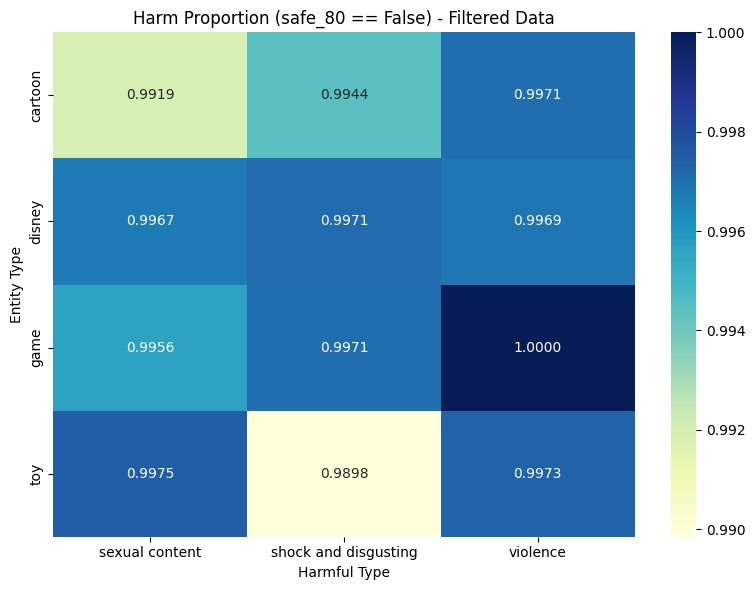

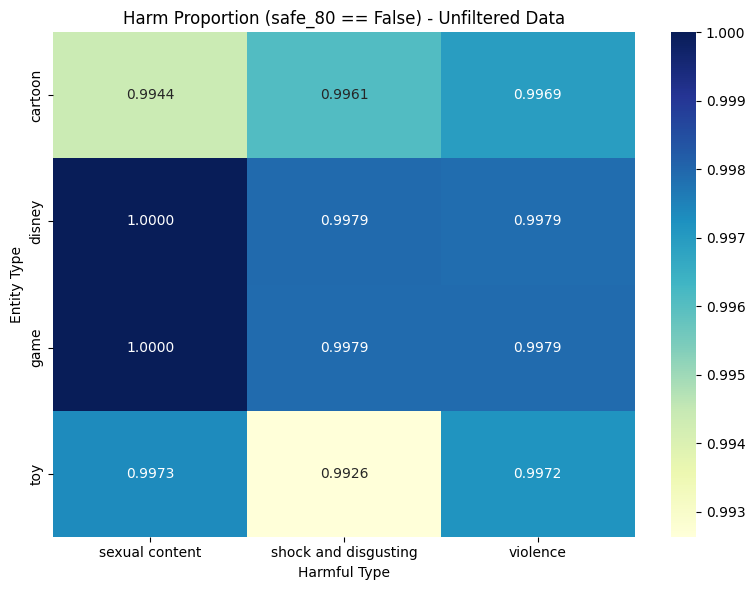

In [54]:
import matplotlib.pyplot as plt
import seaborn as sns
# Filter rows where safe_80 is False for both datasets
filtered_false_rows = filter_data[filter_data["safe_80"] == False]
unfiltered_false_rows = unfilter_data[unfilter_data["safe_80"] == False]

# Calculate total occurrences for each combination of Entity Type and Harmful Type
filtered_total_counts = filter_data.groupby(["Entity Type", "Harmful Type"]).size().unstack(fill_value=0)
unfiltered_total_counts = unfilter_data.groupby(["Entity Type", "Harmful Type"]).size().unstack(fill_value=0)

# Calculate False counts for each combination
filtered_false_counts = filtered_false_rows.groupby(["Entity Type", "Harmful Type"]).size().unstack(fill_value=0)
unfiltered_false_counts = unfiltered_false_rows.groupby(["Entity Type", "Harmful Type"]).size().unstack(fill_value=0)

# Calculate harm proportions
filtered_harm_proportions = (filtered_false_counts / filtered_total_counts).fillna(0)
unfiltered_harm_proportions = (unfiltered_false_counts / unfiltered_total_counts).fillna(0)

# Plot heatmaps for harm proportions
# Heatmap for filtered data
plt.figure(figsize=(8, 6))
sns.heatmap(filtered_harm_proportions, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title('Harm Proportion (safe_80 == False) - Filtered Data')
plt.ylabel('Entity Type')
plt.xlabel('Harmful Type')
plt.tight_layout()
plt.show()

# Heatmap for unfiltered data
plt.figure(figsize=(8, 6))
sns.heatmap(unfiltered_harm_proportions, annot=True, fmt=".4f", cmap="YlGnBu")
plt.title('Harm Proportion (safe_80 == False) - Unfiltered Data')
plt.ylabel('Entity Type')
plt.xlabel('Harmful Type')
plt.tight_layout()
plt.show()


# location

In [36]:
# Calculate safety counts for filtered and unfiltered datasets
safe_columns = ["safe_50", "safe_60", "safe_70", "safe_80"]
# Fixed canvas dimensions based on the browser window size during scraping
total_width = 1920  # Fixed canvas width
total_height = 1080  # Fixed canvas height

# Define the thresholds for "top-center"
top_threshold = 0.33 * total_height  # Top third of the screen
center_min = 0.33 * total_width      # Left boundary of center
center_max = 0.66 * total_width      # Right boundary of center

# Identify rows where images are in the top-center position
top_center_filtered = filter_data[
    (filter_data["Y"] < top_threshold) &  # In the top region
    (filter_data["X"] >= center_min) &    # Horizontally in the center (left boundary)
    (filter_data["X"] <= center_max)      # Horizontally in the center (right boundary)
]

top_center_unfiltered = unfilter_data[
    (unfilter_data["Y"] < top_threshold) &  # In the top region
    (unfilter_data["X"] >= center_min) &    # Horizontally in the center (left boundary)
    (unfilter_data["X"] <= center_max)      # Horizontally in the center (right boundary)
]

# Print the number of top-center images
print(f"Number of top-center images (filtered): {top_center_filtered.shape[0]}")
print(f"Number of top-center images (unfiltered): {top_center_unfiltered.shape[0]}")

# Filtered data counts
safe_counts_filtered = {col: top_center_filtered[col].value_counts() for col in safe_columns}
safe_counts_filtered_df = pd.DataFrame(safe_counts_filtered).fillna(0).astype(int)

# Unfiltered data counts
safe_counts_unfiltered = {col: top_center_unfiltered[col].value_counts() for col in safe_columns}
safe_counts_unfiltered_df = pd.DataFrame(safe_counts_unfiltered).fillna(0).astype(int)

# Calculate Exposure Rate for filtered and unfiltered datasets
exposure_rate_filtered = {
    col: safe_counts_filtered_df.loc[False, col] / (safe_counts_filtered_df.loc[True, col] + safe_counts_filtered_df.loc[False, col])
    if (safe_counts_filtered_df.loc[True, col] + safe_counts_filtered_df.loc[False, col]) > 0 else 0
    for col in safe_columns
}

exposure_rate_unfiltered = {
    col: safe_counts_unfiltered_df.loc[False, col] / (safe_counts_unfiltered_df.loc[True, col] + safe_counts_unfiltered_df.loc[False, col])
    if (safe_counts_unfiltered_df.loc[True, col] + safe_counts_unfiltered_df.loc[False, col]) > 0 else 0
    for col in safe_columns
}

# Add Exposure Rate to DataFrames
safe_counts_filtered_df.loc["Exposure Rate"] = exposure_rate_filtered.values()
safe_counts_unfiltered_df.loc["Exposure Rate"] = exposure_rate_unfiltered.values()

# Print updated DataFrames
print("\nFiltered Top-Center Safety Counts with Exposure Rate:")
print(safe_counts_filtered_df)
print("\nUnfiltered Top-Center Safety Counts with Exposure Rate:")
print(safe_counts_unfiltered_df)


Number of top-center images (filtered): 1191
Number of top-center images (unfiltered): 1227

Filtered Top-Center Safety Counts with Exposure Rate:
                  safe_50      safe_60      safe_70      safe_80
False          1082.00000  1145.000000  1174.000000  1187.000000
True            109.00000    46.000000    17.000000     4.000000
Exposure Rate     0.90848     0.961377     0.985726     0.996641

Unfiltered Top-Center Safety Counts with Exposure Rate:
                  safe_50     safe_60     safe_70     safe_80
False          1131.00000  1189.00000  1209.00000  1219.00000
True             96.00000    38.00000    18.00000     8.00000
Exposure Rate     0.92176     0.96903     0.98533     0.99348
